### Independent component analysis (ICA)
ICA is a technique for estimating independent source signals from a set of recordings in which the source signals were mixed together in unknown ratios. ICA can be used for artifact repair like rapair of ocular or heartbeat artifacts.
https://en.wikipedia.org/wiki/Independent_component_analysis

In [18]:
import mne
import pandas as pd
import os 
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [19]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax=60)

Opening raw data file C:\Users\AlbalooCo\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~3.3 MB, data not loaded>

## Visualizing the artifacts

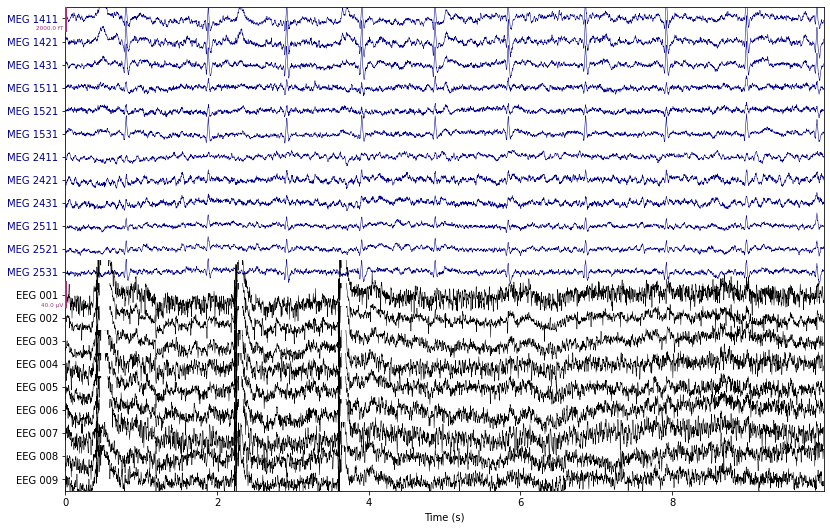

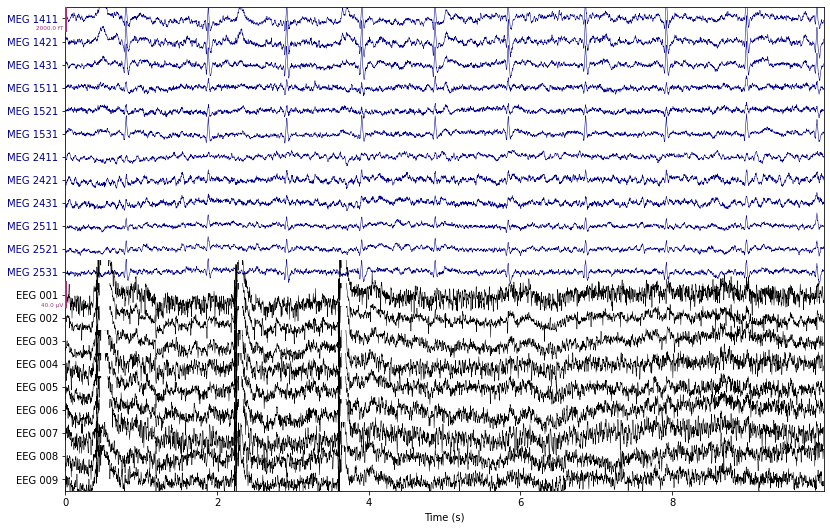

In [25]:
# pick some channels that clearly show heartbeats and blinks
regexp = r'(MEG [12][45][123]1|EEG 00.)'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
         show_scrollbars=False)

Summary of how the ocular artifact manifests across each channel type using **create_eog_epochs**

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected : 10
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Loading data for 10 events and 601 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)

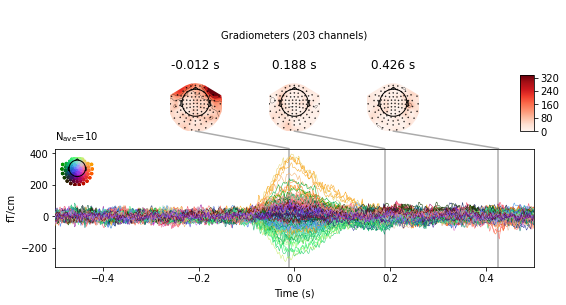

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


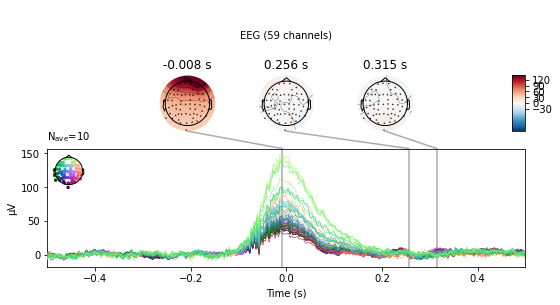

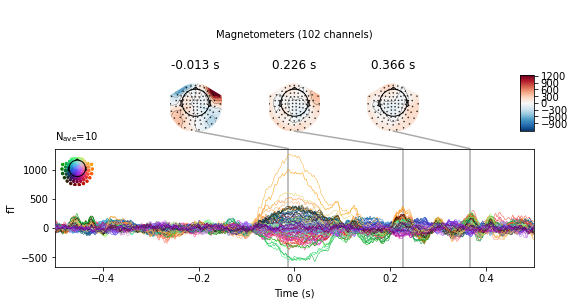

[<Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>]

In [28]:
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Same for the heartbeat artifacts

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Number of ECG events detected : 59 (average pulse 58 / min.)
Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Loading data for 59 events and 601 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
Removing projector <Projection | 

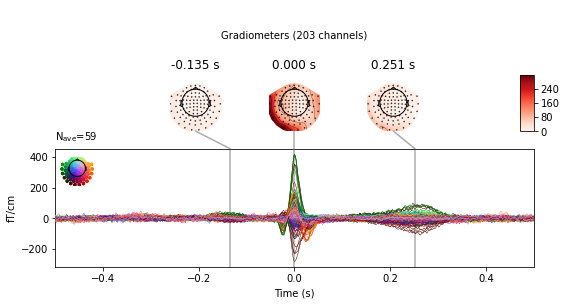

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


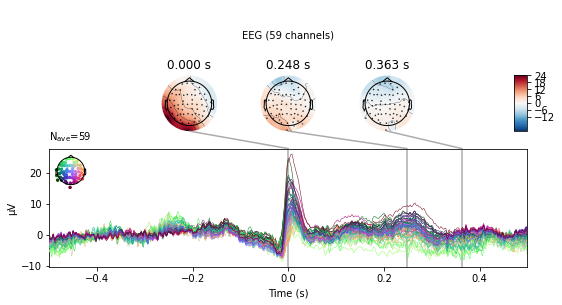

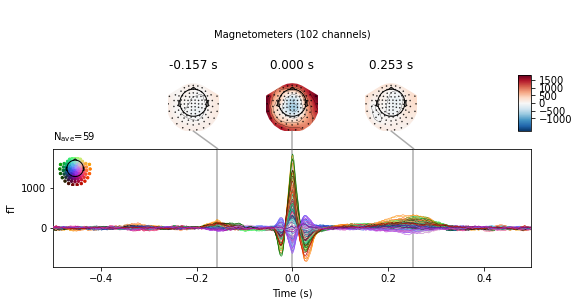

[<Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>]

In [30]:
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

## Filtering to remove slow drifts

The slow drifts are problematic because they reduce the independence of the assumed-to-be-independent sources (e.g., during a slow upward drift, the neural, heartbeat, blink, and other muscular sources will all tend to have higher values), making it harder for the algorithm to find an accurate solution.

In [34]:
filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq=1., h_freq=None)

Reading 0 ... 36037  =      0.000 ...    60.000 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1983 samples (3.302 sec)



<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

## Fitting and plotting the ICA solution

In [40]:
ica = ICA(n_components=15, max_iter=200, random_state=97)
ica.fit(filt_raw)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.3s.


<ICA | raw data decomposition, fit (fastica): 36038 samples, 15 components, channels used: "mag"; "grad"; "eeg">

Creating RawArray with float64 data, n_channels=16, n_times=36038
    Range : 25800 ... 61837 =     42.956 ...   102.956 secs
Ready.


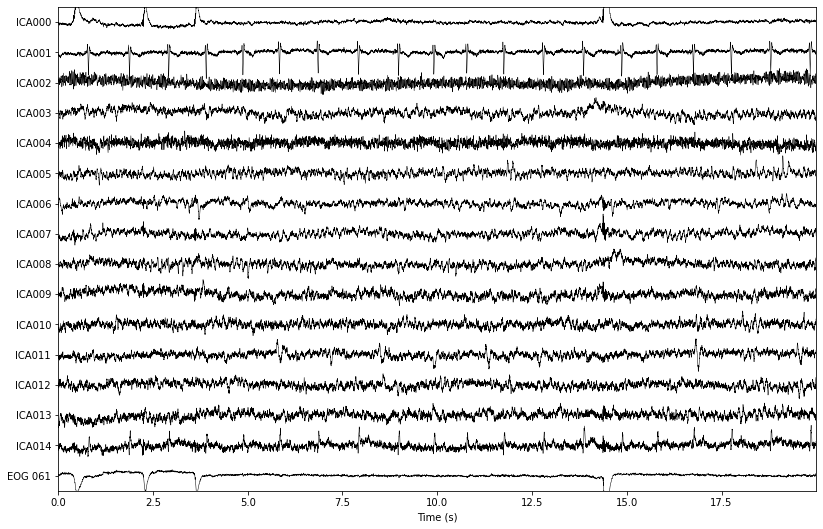

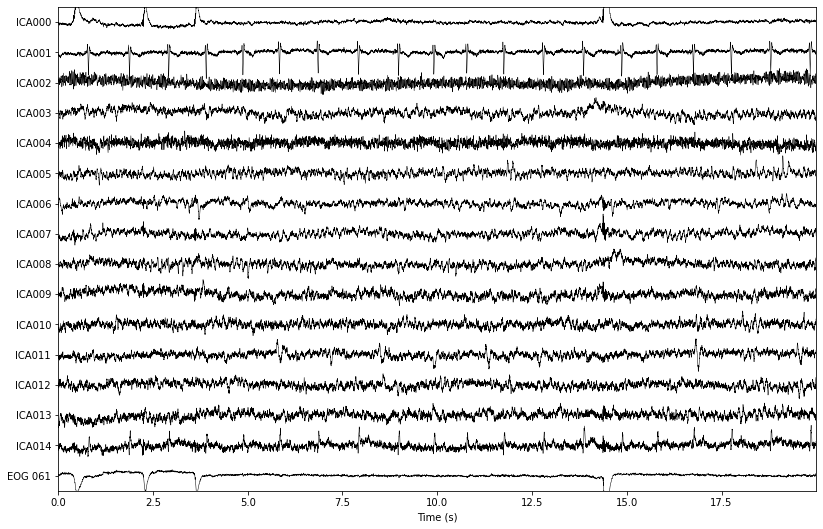

In [41]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

Here we can pretty clearly see that the first component (ICA000) captures the EOG signal quite well, and the second component (ICA001) looks a lot like a heartbeat.

visualize the scalp field distribution of each component using **plot_components**. These are interpolated based on the values in the ICA mixing matrix:

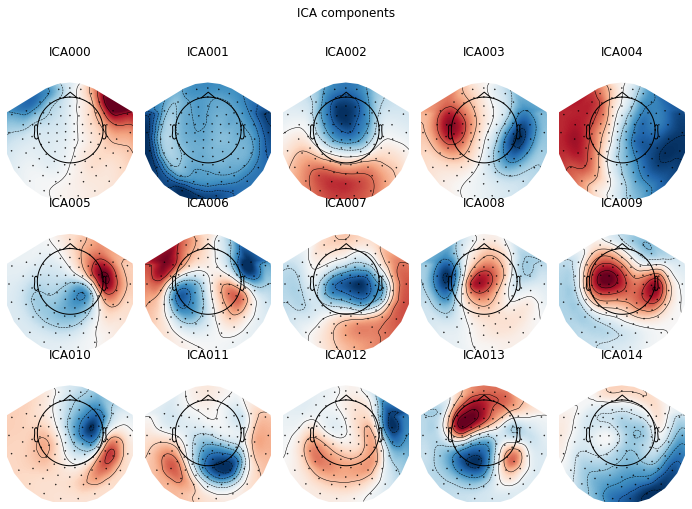

[<Figure size 702x508.68 with 15 Axes>]

In [44]:
ica.plot_components()

plot an overlay of the original signal against the reconstructed signal with the artifactual ICs excluded, using **plot_overlay**:

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components


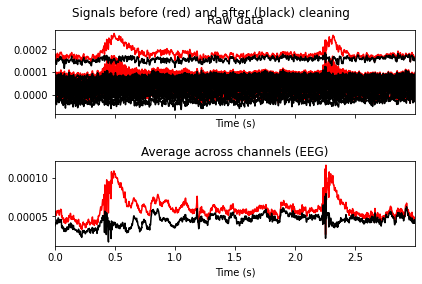

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components


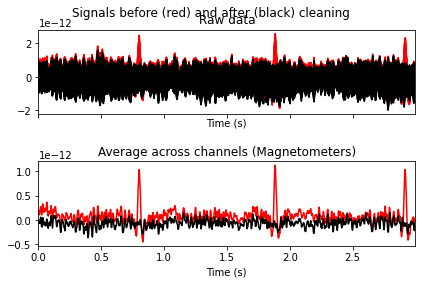

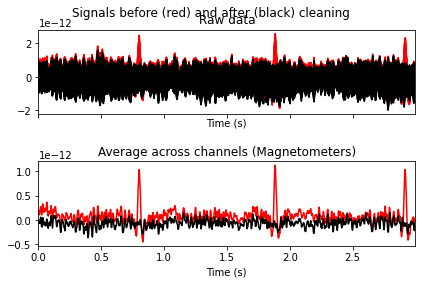

In [46]:
# blinks
ica.plot_overlay(raw, exclude=[0], picks='eeg')
# heartbeats
ica.plot_overlay(raw, exclude=[1], picks='mag')